# **Task 5: Credit Card fraud detection**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import *
from scipy.stats import randint

In [2]:
# Step 1: Load the Dataset
data = pd.read_csv('creditcard.csv')

In [3]:
# Step 2: Exploratory Data Analysis (EDA)
print(data.head())
print(data.describe())
print(data['Class'].value_counts())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

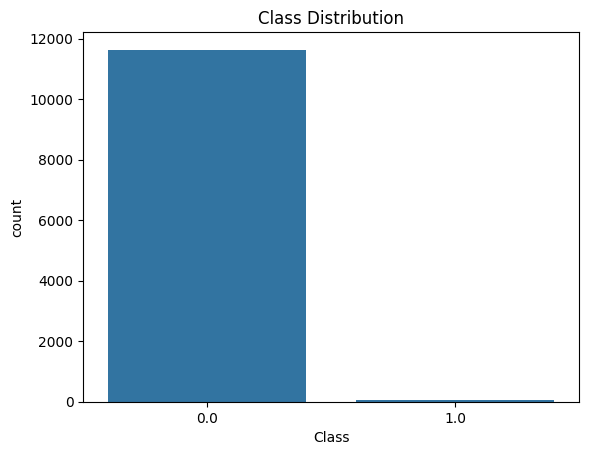

In [4]:
# Plot the class distribution
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

In [5]:
# Step 3: Data Preprocessing
# Check for missing values
print(data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64


In [15]:
# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']


In [16]:
# Handle null values in the target variable
# Remove rows with null target values
data = data.dropna(subset=['Class'])
X = data.drop(columns=['Class'])
y = data['Class']

In [17]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Step 4: Handle Class Imbalance using SMOTE
print("Class distribution before SMOTE:")
print(y.value_counts())

Class distribution before SMOTE:
Class
0.0    11633
1.0       49
Name: count, dtype: int64


In [19]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [20]:
# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

Class distribution after SMOTE:
Class
0.0    11633
1.0    11633
Name: count, dtype: int64


In [21]:
# Verify that the shapes of the resampled data match
print("Original feature shape:", X_scaled.shape)
print("Resampled feature shape:", X_resampled.shape)
print("Original target shape:", y.shape)
print("Resampled target shape:", y_resampled.shape)

# Check for any NaN values introduced during resampling
print("NaN values in resampled features:", np.isnan(X_resampled).sum())
print("NaN values in resampled target:", np.isnan(y_resampled).sum())

Original feature shape: (11682, 30)
Resampled feature shape: (23266, 30)
Original target shape: (11682,)
Resampled target shape: (23266,)
NaN values in resampled features: 0
NaN values in resampled target: 0


In [22]:
# Step 5: Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [47]:

# Step 6: Model Selection and Training
# Define the models and parameters for RandomizedSearchCV
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42)
}

param_distributions = {
    'RandomForest': {
        'n_estimators': randint(100, 200),
        'max_depth': [10, 20, None],
        'min_samples_split': randint(2, 10)
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    }
}

# Hyperparameter tuning using RandomizedSearchCV
best_estimators = {}
for model_name, model in models.items():
    random_search = RandomizedSearchCV(model, param_distributions[model_name], n_iter=10, cv=5, scoring='f1', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    best_estimators[model_name] = random_search.best_estimator_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")

Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 9, 'n_estimators': 129}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for LogisticRegression: {'solver': 'liblinear', 'C': 10}


In [37]:
# Step 7: Model Evaluation
# Evaluate using cross-validation
for model_name, model in best_estimators.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"Cross-validation F1 scores for {model_name}: {cv_scores.mean()}")

In [46]:
# Step 9: Model Testing and Final Evaluation
# Evaluate on the test set
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    print(f"Confusion Matrix for {model_name}:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")

    # Plot Precision-Recall Curve
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()